# CMIP6 Slice Antartica and Greenland/Iceland

**Following steps are included in this script:**

1. Load netCDF files
2. Remove Antartica by removing data south of 60° and Greenland/Iceland using regionmask
   
4. Save and replace netcdf files

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [2]:
def remove_antarctica_greenland_iceland(ds_dict):
    # Define the regions using regionmask
    land_regions = regionmask.defined_regions.ar6.land
    
    # Identify the index for the GIC Greenland/Iceland region
    gic_region_idx = land_regions.map_keys('Greenland/Iceland')
    
    for name, ds in ds_dict.items():
        # Get the mask for the GIC Greenland/Iceland region
        gic_region_mask = land_regions.mask(ds)
        
        # Slice the dataset to exclude Antarctica latitudes
        ds_no_antarctica = ds.sel(lat=(ds.lat > -60))
        
        # Apply the mask to exclude the GIC Greenland/Iceland region
        mask = gic_region_mask == gic_region_idx
        ds_no_gic = ds_no_antarctica.where(~mask, drop=True)

        print(f'Regions removed from {name}.')
        
        # Add comment about changes to data
        if 'log' in ds_no_gic.attrs:
            log_old = ds_no_gic.attrs['log']
            ds_no_gic.attrs['log'] = f'Dataset sliced along lat 60 to remove Antarctica and excluded Greenland and Iceland using regionmask. // {log_old}'
        else:
            ds_no_gic.attrs['log'] = 'Dataset sliced along lat 60 to remove Antarctica and excluded Greenland and Iceland using regionmask.'
        
        ds_dict[name] = ds_no_gic
    
    return ds_dict

### 1. Load netCDF files

In [11]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['CAS-ESM2-0', 'CMCC-ESM2',  'FGOALS-g3', 'GISS-E2-1-H', 'CanESM5-CanOE', 
          'IPSL-CM5A2-INCA', 'KACE-1-0-G','MIROC6', 'MRI-ESM2-0','EC-Earth3-Veg']
          #, 'CMCC-CM2-SR5', 'IPSL-CM6A-LR']#['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1',  'MPI-ESM1-2-LR', 'NorESM2-MM', 'TaiESM1'] #'GFDL-ESM4',
variables=[
               # 'tas',
               #  'ps', 
                 'pr',
               #  'huss', 
               #  'evspsbl', 
        
                'tran', 
               # 'mrso', 
               # 'lai', 
               # 'gpp', 
                'mrro', 
]

# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

[########################################] | 100% Completed | 44.29 s


['historical']


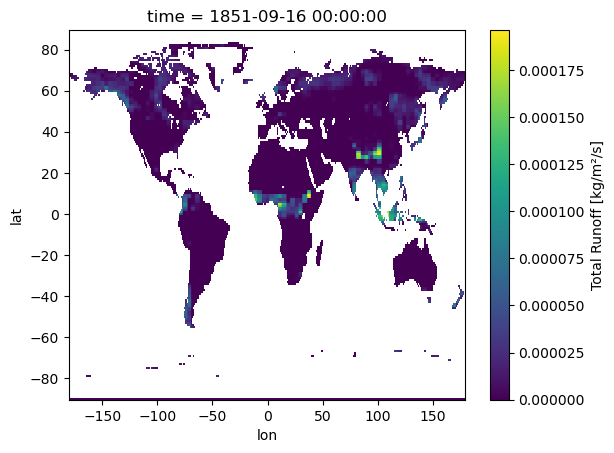

In [7]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[5]][variables[2]].isel(time=20).plot()

### 2. Remove Antartica and Greenland/Iceland

In [12]:
ds_dict = remove_antarctica_greenland_iceland(ds_dict[experiments[0]])

Regions removed from CAS-ESM2-0.
Regions removed from CMCC-ESM2.
Regions removed from FGOALS-g3.
Regions removed from GISS-E2-1-H.
Regions removed from CanESM5-CanOE.
Regions removed from IPSL-CM5A2-INCA.
Regions removed from KACE-1-0-G.
Regions removed from MIROC6.
Regions removed from MRI-ESM2-0.
Regions removed from EC-Earth3-Veg.


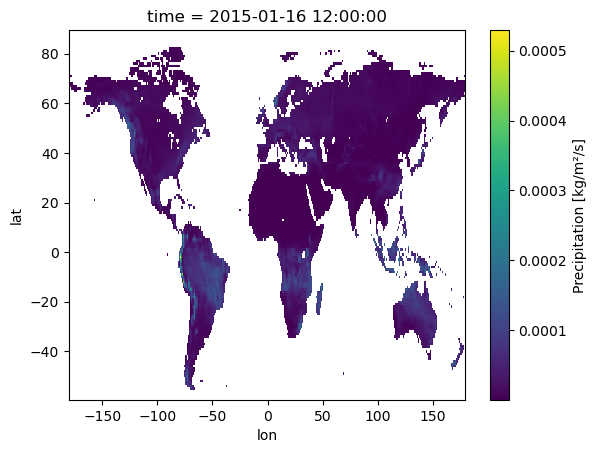

In [13]:
ds_dict[list(ds_dict.keys())[0]][variables[0]].isel(time=0).plot()

### 4. Save and replace netcdf files

In [14]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [15]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/mrro/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/mrro/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/CMCC-ESM2.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/CMCC-ESM2.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/CMCC-ESM2.nc removed
File saved at: /work/ch0636/g300115/phd_project/c